In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/BTP/Wheat

/content/gdrive/.shortcut-targets-by-id/1-luJs84Eus8d8yDA1W4a4Dr54I7ve4nP/BTP/Wheat


# Import TensorFlow and other libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
from tqdm.notebook import tqdm
import pickle 
import shutil

import cv2
from skimage.io import imread as sk_imread, imshow as sk_imshow
from skimage.transform import resize as sk_resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

from tabulate import tabulate
import math

In [4]:
DATA_DIR = 'dataset'

def get_file_paths(main_dir):
  file_paths = {}
  for root, dir, files in os.walk(main_dir):
    if root == main_dir:
      continue
    class_damage = os.path.basename(root)
    file_paths[class_damage] = [os.path.join(root, filename) for filename in files]
  return file_paths

FILE_PATHS = get_file_paths(DATA_DIR)
print('classes found: ', FILE_PATHS.keys())
print('sample path:', FILE_PATHS['Shrivel'][0])

classes found:  dict_keys(['Healthy', 'Shrivel', 'Black', 'Chalky', 'Green'])
sample path: dataset/Shrivel/S01198.JPG


In [5]:
test_paths = []
for damage in FILE_PATHS.keys():
  inds = np.random.randint(1, 100, 10)
  test_paths.extend(np.array(FILE_PATHS[damage])[inds])
#print(test_paths[0])
true_class = [x.split('/')[1] for x in test_paths]
print(true_class)

['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Shrivel', 'Black', 'Black', 'Black', 'Black', 'Black', 'Black', 'Black', 'Black', 'Black', 'Black', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Chalky', 'Green', 'Green', 'Green', 'Green', 'Green', 'Green', 'Green', 'Green', 'Green', 'Green']


In [6]:
IMG_HEIGHT = 300
IMG_WIDTH = 200
IMG_CHANNELS = 3

model = tf.keras.models.load_model('models/MobileNetV3/model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
OHE_classes = np.array(['Black','Chalky','Green','Healthy','Shrivel'], dtype=object)

In [7]:
#model.get_layer('MobileNetV3').summary()

In [8]:
#tf.keras.models.Sequential(base)

In [9]:
#tf.keras.utils.plot_model(tf.keras.models.Sequential(base), 'resnet50')

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 200, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 MobilenetV3large (Functiona  (None, 10, 7, 960)       2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 4805      
                                                                 
Total params: 3,001,157
Trainable params: 2,976,757
Non-train

In [11]:
def predict(img_path):
  img = cv2.resize(sk_imread(img_path), (IMG_WIDTH, IMG_HEIGHT))
  y = model.predict(img[np.newaxis, :, :, :])
  return OHE_classes[np.argmax(y)]

In [12]:
def PolyArea2D(pts):
      lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
      area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
      return area
def getParams(source):
    image = cv2.imread(source)
    image_resized = cv2.resize(image, (200, 300))
    img_hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img_hsv, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 160, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    image_contour = image_resized.copy()
    image_contour = cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB)
    c = max(contours, key = cv2.contourArea)
    cv2.drawContours(image=image_contour, contours=[c], contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    ellipse = cv2.fitEllipse(c)
    a,b = ellipse[1]
    a, b = a/2, b/2
    image_ellipse = image_resized.copy()
    cv2.ellipse(image_ellipse,ellipse,(0,0,255),2)
    image_ellipse = cv2.cvtColor(image_ellipse, cv2.COLOR_BGR2RGB)
    hull = cv2.convexHull(c)
    image_hull = image_resized.copy()
    cv2.drawContours(image=image_hull, contours=[hull], contourIdx=-1, color=(0, 255, 255), thickness=2, lineType=cv2.LINE_AA)
    image_hull = cv2.cvtColor(image_hull, cv2.COLOR_BGR2RGB)
    print(source)
    plt.figure(figsize = (15,15))
    ax = plt.subplot(1,3,1)
    plt.imshow(image_contour)
    plt.axis("off")
    ax = plt.subplot(1,3,2)
    plt.imshow(image_ellipse)
    plt.axis("off")
    ax = plt.subplot(1,3,3)
    plt.imshow(image_hull)
    plt.axis("off")
    plt.show()
    data = [['Actual Area', cv2.contourArea(c)], 
            ['Perimeter', cv2.arcLength(c,True)], 
            ['Major axis of Ellipse',  max(a , b)], 
            ['Minor axis of Ellipse',  min(a , b)], 
            ['Area of Ellipse', math.pi*a*b], 
            ['Eccentricity of ellipse', np.sqrt(1 - np.square(a)/np.square(b))], 
            ['Aspect Ratio', max(a,b)/min(a,b)], 
            ['Area of Rectangle', a*b*4], 
            ['Area of convex hull', PolyArea2D(np.squeeze(hull))], 
            ['Extent', (a*b*4)/cv2.contourArea(c)], 
            ['Solidity', PolyArea2D(np.squeeze(hull))/cv2.contourArea(c)], 
            ['Roundness', (4*math.pi*cv2.contourArea(c))/np.square(cv2.arcLength(c,True))], 
            ['Equivalent Diameter', np.sqrt((4*cv2.contourArea(c))/math.pi)], 
            ['Compactness', np.sqrt((4*cv2.contourArea(c))/math.pi)/max(a, b)], 
            ['Shape Factor 1', max(a, b)/cv2.contourArea(c)], 
            ['Shape Factor 2', max(a, b)/cv2.contourArea(c)], 
            ['Shape Factor 3', cv2.contourArea(c)/(math.pi*np.square(max(a, b)))], 
            ['Shape Factor 4', (cv2.contourArea(c)*max(a, b))/math.pi]]
    print(tabulate(data, tablefmt="grid"))

Black
B00013.JPG


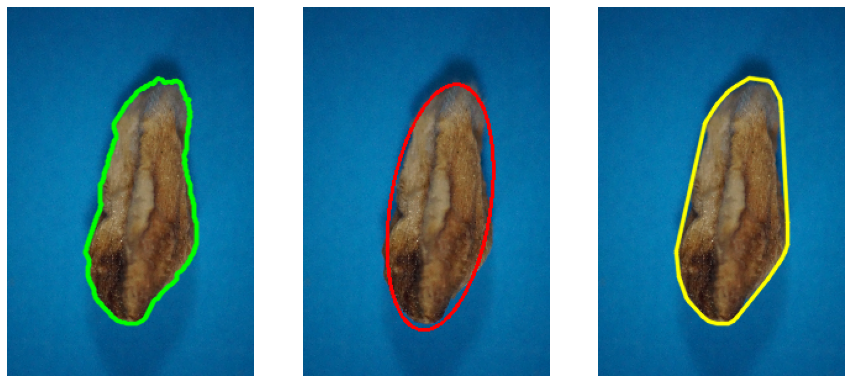

+-------------------------+-----------------+
| Actual Area             |  12358          |
+-------------------------+-----------------+
| Perimeter               |    519.588      |
+-------------------------+-----------------+
| Major axis of Ellipse   |    100.638      |
+-------------------------+-----------------+
| Minor axis of Ellipse   |     40.5695     |
+-------------------------+-----------------+
| Area of Ellipse         |  12826.6        |
+-------------------------+-----------------+
| Eccentricity of ellipse |      0.915146   |
+-------------------------+-----------------+
| Aspect Ratio            |      2.48063    |
+-------------------------+-----------------+
| Area of Rectangle       |  16331.4        |
+-------------------------+-----------------+
| Area of convex hull     |  13113          |
+-------------------------+-----------------+
| Extent                  |      1.32152    |
+-------------------------+-----------------+
| Solidity                |      1

In [14]:
img_path = 'B00013.JPG'
print(predict(img_path))
getParams(img_path)